In [2]:

import numpy as np
import pandas as pd
import sys, os
rawdir = "../data/raw/"
processeddir = "../data/processed/"
tripdatadf = pd.read_csv(os.path.join(rawdir, "trip_data_4.csv"), dtype={" store_and_fwd_flag": "object"})
tripfaredf = pd.read_csv(os.path.join(rawdir, "trip_fare_4.csv"))

In [3]:
# strip spaces from start of col headers
tripdatadf.columns = list(map(str.lstrip, tripdatadf.columns))
tripfaredf.columns = list(map(str.lstrip, tripfaredf.columns))


In [4]:
#check nrows matches
tripdatadf.shape[0] == tripfaredf.shape[0]

True

In [19]:
#join on hack license, medallion and pickup_datetime

df = tripdatadf.merge(tripfaredf, on=["medallion", "hack_license", "pickup_datetime"])

#look for failed matches

assert(np.sum(pd.isnull(df["rate_code"]))==0)
assert(np.sum(pd.isnull(df["total_amount"]))==0)

In [22]:
#coerce datetimes
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

#add 15% cash tip to cash tip trips
row_indexer = df["tip_amount"]==0 #we are modifying this condition so need to save which rows first
df.loc[row_indexer, "tip_amount"] = df.loc[row_indexer, "fare_amount"] * .15
df.loc[row_indexer, "total_amount"] += df.loc[row_indexer, "fare_amount"] * .15

In [35]:
# drop rows with no dropoff location and trip distance zero
df = df.loc[~pd.isnull(df['dropoff_longitude'])]

In [1]:
#add pickup and dropoff "neighbourhood" name
import shapefile
import pyproj
from shapely.geometry import shape, Point, mapping
cache = {}
def load_shapes(filename=rawdir+"taxi_zones/taxi_zones"):
    sf = shapefile.Reader(filename)

    shapes = list(map(lambda x: shape(x.__geo_interface__), sf.shapes()))
    import pdb;pdb.set_trace()
    centroids = list(map(lambda x: shape(x.__geo_interface__).centroid, sf.shapes()))
    

    df = pd.DataFrame(sf.records())
    df = df.rename(columns={3:"name"})
    neighbourhood_json = list(map(lambda x: x.__geo_interface__, sf.shapes()))

    neighbourhood_json = {'type': 'FeatureCollection',
                'features': [{'type':'Feature', 'geometry':x, 'properties': {'name':df.iloc[i]['name']}} for i, x in enumerate(neighbourhood_json)]
              }


    return shapes, centroids, neighbourhood_json, df

def round_m(point):
    #round to the nearest meter to increase cache hits
    #at 40deg north, 5 decimal places gives you ~80cm accuracy
    return ("%.5f" % point.x, "%.5f" % point.y)

def which_neighbourhood(trippoints, shapes, df):
    output = []
    import pdb;pdb.set_trace()
    
    for pickup_point, dropoff_point in trippoints:
        pickup_name = ""
        dropoff_name = ""
        if round_m(pickup_point) in cache:
            pickup_name = cache[(pickup_point.x, pickup_point.y)]
        if round_m(dropoff_point) in cache:
            dropoff_name = cache[(dropoff_point.x, dropoff_point.y)]
            
        if not pickup_name or not dropoff_name:
            for i, shape in enumerate(shapes):
                if pickup_point.within(shape):
                    pickup_name = df.iloc[i].name
                    cache[round_m(pickup_point)] = pickup_name
                if dropoff_point.within(shape):
                    dropoff_name = df.iloc[i].name
                    cache[round_m(dropoff_point)] = dropoff_name
                if pickup_name and dropoff_name:
                    break
            if not pickup_name:                
                #outside NYC
                pickup_name = "OutsideNYC"
            if not dropoff_name:
                dropoff_name = "OutsideNYC"
        output.append((pickup_name, dropoff_name))
            
    return pd.Series(output)

shapes, centroids, geojson, namedf = load_shapes()

ModuleNotFoundError: No module named 'pyproj'

In [39]:
len(trip_points)

0

In [51]:
trip_points = []

for index, x in df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].iterrows():
    trip_points.append((shape(Point(x['pickup_longitude'], x['pickup_latitude'])),
                        shape(Point(x['dropoff_longitude'], x['dropoff_latitude']))))


In [57]:
output = which_neighbourhood(trip_points[:1000], shapes, namedf)

> <ipython-input-56-9a750df8b2d5>(31)which_neighbourhood()
-> for pickup_point, dropoff_point in trippoints:
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(32)which_neighbourhood()
-> pickup_name = ""
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(33)which_neighbourhood()
-> dropoff_name = ""
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(34)which_neighbourhood()
-> if round_m(pickup_point) in cache:
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(36)which_neighbourhood()
-> if round_m(dropoff_point) in cache:
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(39)which_neighbourhood()
-> if not pickup_name or not dropoff_name:
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(40)which_neighbourhood()
-> for i, shape in enumerate(shapes):
(Pdb) len(shapes)
263
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(41)which_neighbourhood()
-> if pickup_point.within(shape):
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(44)which_neighbourhood()
-> if dropoff_point.within(shape):
(Pdb) n
> <ipython-input-56-9a750df8b2d5>(47)which_neighbourhood(

BdbQuit: 

In [53]:
df["pickup_neighbourhood"] = list(map(lambda x: x[0], output))
df["dropoff_neighbourhood"] = list(map(lambda x: x[1], output))

KeyboardInterrupt: 

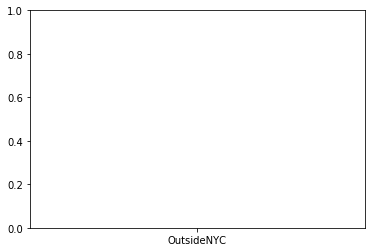

In [54]:
df["pickup_neighbourhood"].hist()

In [55]:
df.groupby("pickup_neighbourhood").count()

,medallion,hack_license,vendor_id_x,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_latitude,vendor_id_y,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,dropoff_neighbourhood
pickup_neighbourhood,,,,,,,,,,,,,,,,,,,,,
OutsideNYC,15101626,15101626,15101626,15101626,7582061,15101626,15101626,15101626,15101626,15101626,...,15101626,15101626,15101626,15101626,15101626,15101626,15101626,15101626,15101626,15101626


In [6]:
# write out
outerdf= tripdatadf.merge(tripfaredf, on=["medallion", "hack_license", "pickup_datetime"], how="outer")
outerdf

,medallion,hack_license,vendor_id_x,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_longitude,dropoff_latitude,vendor_id_y,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,N,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.50,...,-73.976273,40.785648,CMT,CRD,11.0,1.0,0.5,2.50,0.00,15.00
1,EC34CD1B3797DFAFF3FE099BA87B6656,8FE6A4AEDF89B6B4E19D2377FD3FB7D7,CMT,1,N,2013-04-05 07:08:34,2013-04-05 07:17:34,1,540,1.60,...,0.000000,0.000000,CMT,CRD,8.5,0.0,0.5,1.80,0.00,10.80
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,E1B595FD55E4C82C1E213EB17438107A,CMT,1,N,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.60,...,-74.009186,40.715374,CMT,CRD,16.5,1.0,0.5,3.60,0.00,21.60
3,9BA84250355AB3FC031C9252D395BF8A,16BB0D96A0DCC853AEC7F55C8D6C71E0,CMT,1,N,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.90,...,-73.955666,40.776642,CMT,CRD,10.0,1.0,0.5,3.45,0.00,14.95
4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,N,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.60,...,-73.961662,40.761082,CMT,CRD,15.0,0.5,0.5,3.20,0.00,19.20
5,EE75E5927D00739AC342810C336A825E,1B4E92431F9DA4D49874EC76E769E874,CMT,1,N,2013-04-05 02:48:11,2013-04-05 02:51:21,2,189,0.70,...,-73.990776,40.747997,CMT,CRD,4.5,0.5,0.5,1.10,0.00,6.60
6,3B5DA0DE0868F37FD41204DB36CE87CA,BC7B6E5A0132450CAE072F3C8F60BBE4,CMT,1,N,2013-04-05 06:16:10,2013-04-05 06:22:05,1,354,1.20,...,-73.978867,40.751144,CMT,CRD,6.5,0.0,0.5,1.00,0.00,8.00
7,00B99071EE4DC8266384113B91E6AC13,013DB7F394A06CD241688F0F3E93F2F1,CMT,1,N,2013-04-05 06:20:10,2013-04-05 06:27:43,1,452,1.60,...,-74.002747,40.756168,CMT,CRD,8.0,0.0,0.5,2.10,0.00,10.60
8,75FEF473DB69BA7BC5D61F5635792E1E,FCD2C03A60D84CE91A4DEB5E6A097FCF,CMT,1,N,2013-04-04 19:20:16,2013-04-04 19:30:52,1,635,0.40,...,-73.984566,40.759415,CMT,CRD,7.5,1.0,0.5,2.25,0.00,11.25
9,13A57EE874E2560DF1F9D6C639BB7DAB,5FE3733438871FE98C05D259E8693750,CMT,1,N,2013-04-03 18:05:38,2013-04-03 18:23:06,1,1048,2.40,...,-73.988472,40.756004,CMT,CRD,12.5,1.0,0.5,2.80,0.00,16.80


In [8]:
#spatially aware sample? or just whole dataset
processeddir = "../data/processed/"
df.to_csv(os.path.join(processeddir,"nyctaxiclean.csv"))